## Assigment 3

In [475]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from os import walk

### Exercise 1

#### A

- Ix (x,y) = [g(y) * I(x, y)] * dg(x) / dx
- Iy (x, y) = [g(x) * I(x, y)] * dg(y) / dy
- Ixx (x, y) = [g(y) * Ix (x, y)] * dg(x) / dx
- Iyy (x, y) = [g(x) * Iy(x, y)] * dg(y) / dy
- Ixy (x, y) = [g(x) * Ix (x, y)] * dg(y) / dy
- Iyx (x, y) = [g(y) * Iy (x,y)] * dg(x) / dx

#### B

In [476]:
def gaussdx(sigma):
    f = lambda x: np.exp(-x**2/(2*sigma**2)) * (-x/(np.sqrt(2*np.pi) * sigma**3))
    r = np.array(list(map(f, np.arange(-3*sigma, 3*sigma+1))))
    return (r / sum(abs(r))).reshape(1, r.shape[0])

def gaussian(sigma):
    f = lambda x: np.exp(-x**2/(2*sigma**2)) / (np.sqrt(2*np.pi) * sigma)
    r = np.array(list(map(f, np.arange(-3*sigma, 3*sigma+1))))
    return (r / sum(r)).reshape(1, r.shape[0])

In [477]:
g = gaussian(2)
print("Sum:", np.sum(g))
print("Abs Sum:", np.sum(abs(g)))
g[0, :]

Sum: 0.9999999999999999
Abs Sum: 0.9999999999999999


array([0.0022182 , 0.00877313, 0.02702316, 0.06482519, 0.12110939,
       0.17621312, 0.19967563, 0.17621312, 0.12110939, 0.06482519,
       0.02702316, 0.00877313, 0.0022182 ])

In [478]:
gdx = -gaussdx(2)
print("Sum:", np.sum(gdx))
print("Abs Sum:", np.sum(abs(gdx)))
gdx[0, :]

Sum: 3.469446951953614e-18
Abs Sum: 1.0000000000000002


array([-0.00855153, -0.02818497, -0.06945265, -0.12495619, -0.1556326 ,
       -0.11322205, -0.        ,  0.11322205,  0.1556326 ,  0.12495619,
        0.06945265,  0.02818497,  0.00855153])

#### C

In [479]:
impulse = np.zeros((51, 51))
impulse[25, 25] = 1

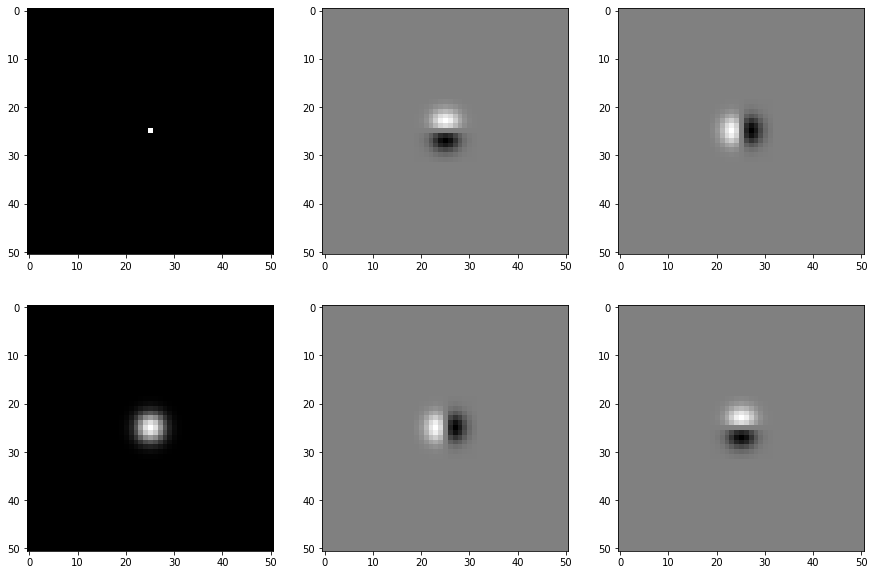

In [480]:
kernels =   [[      None,   (g, gdx.T), (gdx, g.T)  ],
            [   (g.T, g),   (g.T, gdx), (gdx.T, g)  ]]

figure, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(axes)):
    for j in range(len(axes[i])):
        img = impulse.copy()
        if kernels[i][j] is not None:
            img = cv2.filter2D(img, -1, kernel=kernels[i][j][0])
            img = cv2.filter2D(img, -1, kernel=kernels[i][j][1])
        axes[i][j].imshow(img, cmap='gray')


#### D

In [481]:
def imgDX(I):
    return cv2.filter2D(cv2.filter2D(I, -1, kernel=g.T), -1, kernel=gdx)

def imgDY(I):
    return cv2.filter2D(cv2.filter2D(I, -1, kernel=g), -1, kernel=gdx.T)

def imgDXX(I):
    return imgDX(imgDX(I))

def imgDXY(I):
    return imgDY(imgDX(I))

def imgDYX(I):
    return imgDX(imgDY(I))

def imgDYY(I):
    return imgDY(imgDY(I))


In [482]:
def gradient_magnitude(I):
    magnitude = np.sqrt(imgDX(I)**2 + imgDY(I)**2)
    angle = np.arctan2(imgDY(I), imgDX(I))
    return magnitude, angle

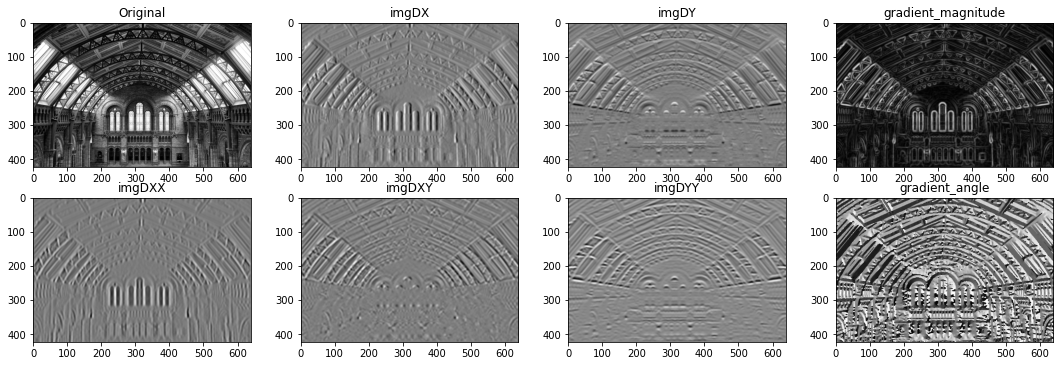

In [483]:
original = cv2.imread('./assigments/assigment3/images/museum.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float64)

fig, axes = plt.subplots(2, 4, figsize=(15, 5))
fig.tight_layout(pad=1.0)

axes[0, 0].imshow(original, cmap='gray')
axes[0, 0].set_title('Original')

axes[0, 1].imshow(imgDX(original), cmap='gray')
axes[0, 1].set_title('imgDX')

axes[0, 2].imshow(imgDY(original), cmap='gray')
axes[0, 2].set_title('imgDY')

axes[0, 3].imshow(gradient_magnitude(original)[0], cmap='gray')
axes[0, 3].set_title('gradient_magnitude')

axes[1, 0].imshow(imgDXX(original), cmap='gray')
axes[1, 0].set_title('imgDXX')

axes[1, 1].imshow(imgDXY(original), cmap='gray')
axes[1, 1].set_title('imgDXY')

axes[1, 2].imshow(imgDYY(original), cmap='gray')
axes[1, 2].set_title('imgDYY')

axes[1, 3].imshow(gradient_magnitude(original)[1], cmap='gray')
axes[1, 3].set_title('gradient_angle')

pass

#### E

In [484]:
def hist(angle, magnitude, bins=8):
    h = np.zeros(bins)
    for i in range(angle.shape[0]):
        for j in range(angle.shape[1]):
            h[int(angle[i, j] * bins / (2 * np.pi))] += magnitude[i, j]
    return h

def img_hist(I, grid=(8, 8), bins=8):
    h, w = I.shape
    magnitude, angle = gradient_magnitude(I)
    step_h = h // grid[0]
    step_w = w // grid[1]

    hist_img = []
    for i in range(0, h, step_h):
        for j in range(0, w, step_w):
            section_angels = angle[i:i+step_h, j:j+step_w]
            section_magnitude = magnitude[i:i+step_h, j:j+step_w]
            hist_img.extend(hist(section_angels, section_magnitude, bins=bins))
    return np.array(hist_img) / np.sum(hist_img)
    
def chi_square_distance(hist_A, hist_B, e=10**-10):
    return 0.5 * np.sum((hist_A - hist_B) ** 2 / (hist_A + hist_B + e))

In [485]:
directory = "./assigments/assigment2/dataset/"
images = [cv2.imread(directory + f, cv2.IMREAD_GRAYSCALE).astype(np.float64) for f in next(walk(directory))[2]]


In [486]:
histograms = [img_hist(img) for img in images]

In [487]:
N = 10
selected = images[N]
distances = [chi_square_distance(histograms[N], hist) for hist in histograms]
most_similar = np.argsort(distances)

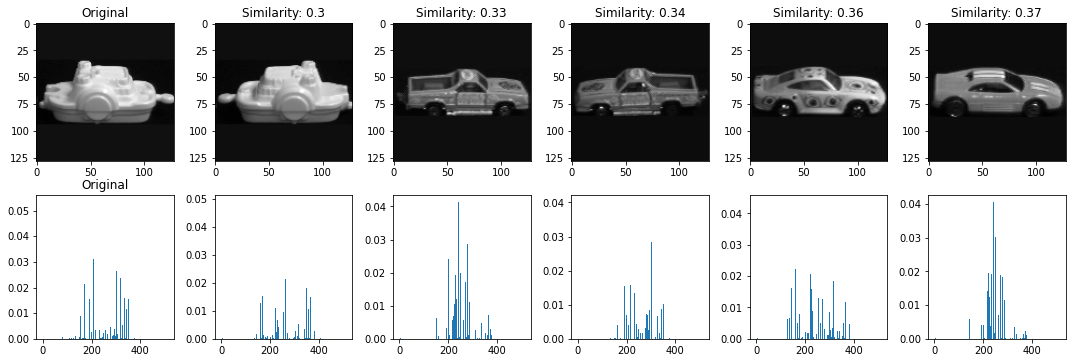

In [488]:
show_n_most_similar = 5
fig, axes = plt.subplots(2, show_n_most_similar + 1, figsize=(15, 5))
fig.tight_layout(pad=1.0)

axes[0, 0].imshow(selected, cmap='gray')
axes[0, 0].set_title('Original')

axes[1, 0].bar(range(len(histograms[N])), histograms[N])
axes[1, 0].set_title('Original')

for i in range(show_n_most_similar):
    axes[0, i+1].imshow(images[most_similar[i +1]], cmap='gray')
    axes[0, i+1].set_title('Similarity: ' + str(round(distances[most_similar[i +1]], 2)))

for i in range(show_n_most_similar):
    axes[1, i +1].bar(range(len(histograms[most_similar[i +1]])), histograms[most_similar[i +1]])

### Exercise 2

#### A

In [489]:
def findedges(I, _, theta):
    mag, _ = gradient_magnitude(I)
    binI = np.zeros_like(mag)
    binI[mag >= theta] = 1
    return binI

In [490]:
museum = cv2.imread("./assigments/assigment3/images/museum.jpg", cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255

Text(0.5, 1.0, 'theta=40')

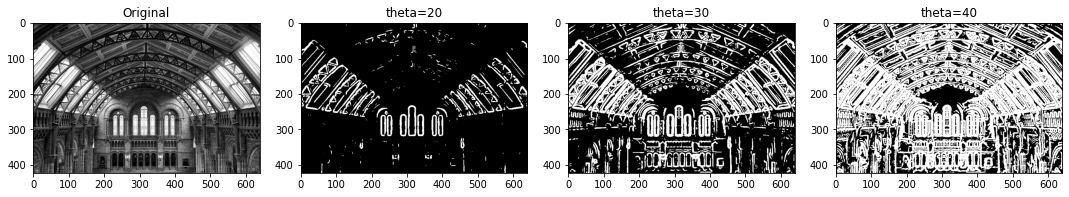

In [491]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.tight_layout(pad=1.0)

axes[0].imshow(museum, cmap='gray')
axes[0].set_title('Original')

axes[1].imshow(findedges(museum, None, 0.16), cmap='gray')
axes[1].set_title('theta=20')

axes[2].imshow(findedges(museum, None, 0.08), cmap='gray')
axes[2].set_title('theta=30')

axes[3].imshow(findedges(museum, None, 0.04), cmap='gray')
axes[3].set_title('theta=40')

#### B

In [492]:

def non_maxima_suppression(rough_edges, magnitude, angles):
    edges = rough_edges.copy()
    discrete_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    directions = [[(0, 1), (0, -1)], [(1, 1), (-1, -1)], [(1, 0), (-1, 0)], [(1, -1), (-1, 1)]]
    for i in range(1, edges.shape[0] - 1):
        for j in range(1, edges.shape[1] - 1):
            if edges[i, j] == 0:
                continue

            aprox_direction = np.argmin(np.abs(discrete_angles - angles[i, j]))
            d = directions[aprox_direction]
            
            if magnitude[i, j] < np.max([magnitude[(i + di, j + dj)] for di, dj in d]):
                edges[i, j] = 0
    return edges

def better_edges(I, theta):
    mag, angles = gradient_magnitude(I)
    rough_edges = np.zeros_like(mag).astype(np.uint8)
    rough_edges[mag >= theta] = 1
    return non_maxima_suppression(rough_edges, mag, angles)

In [516]:
theta = 0.1
museum_thin_edges = better_edges(museum, theta)

Text(0.5, 1.0, 'Thin edges')

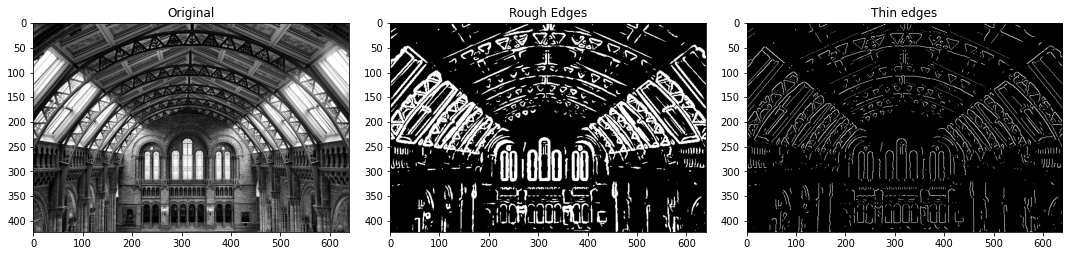

In [517]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.tight_layout(pad=1.0)

axes[0].imshow(museum, cmap='gray')
axes[0].set_title('Original')

axes[1].imshow(findedges(museum, None, theta), cmap='gray')
axes[1].set_title('Rough Edges')

axes[2].imshow(museum_thin_edges, cmap='gray')
axes[2].set_title('Thin edges')

#### C

In [518]:
def hysteresis(thin_edges, magnitude, tlow, thigh):
    # discard low and keep high
    edges = thin_edges.copy()
    edges[magnitude < tlow] = 0

    # discard between and not connected to high
    components, labels  = cv2.connectedComponents(edges, connectivity=4)
    for i in range(1, components):
        if np.max(magnitude[labels == i]) > thigh:
            continue
        edges[labels == i] = 0

    return edges

In [519]:
museum_magnitude, museum_angles = gradient_magnitude(museum)
print(museum_magnitude.min(), museum_magnitude.max())

1.371419323662774e-18 0.4495631248993536


In [522]:
print("theat", theta)
museum_hysteris = hysteresis(museum_thin_edges, museum_magnitude, theta/8, theta)

theat 0.1


Text(0.5, 1.0, 'Hysteresis')

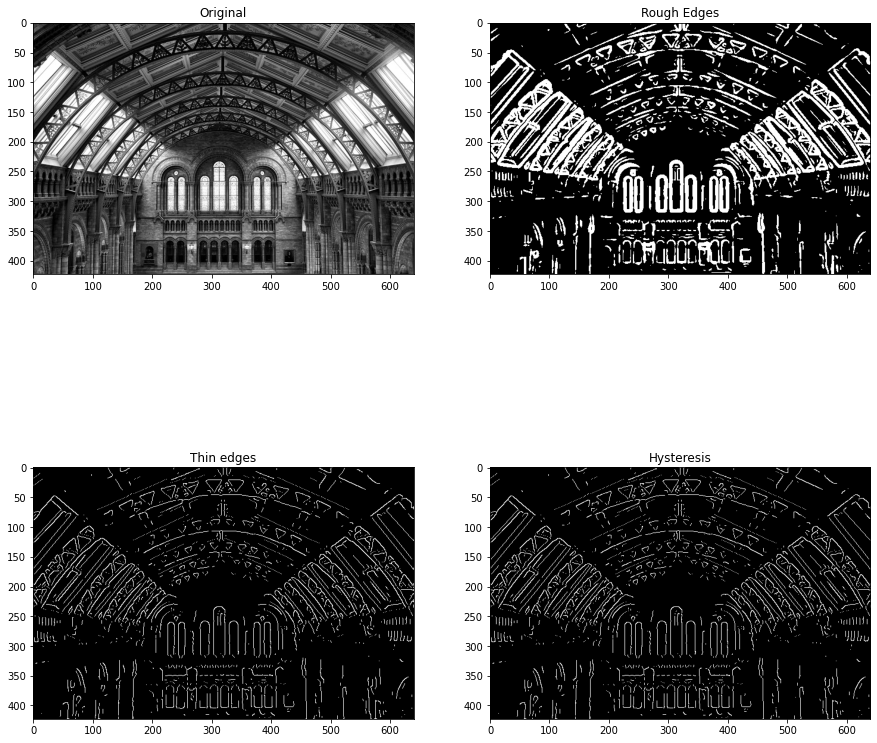

In [523]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

axes[0, 0].imshow(museum, cmap='gray')
axes[0, 0].set_title('Original')

axes[0, 1].imshow(findedges(museum, None, theta), cmap='gray')
axes[0, 1].set_title('Rough Edges')

axes[1, 0].imshow(museum_thin_edges, cmap='gray')
axes[1, 0].set_title('Thin edges')

axes[1, 1].imshow(museum_hysteris, cmap='gray')
axes[1, 1].set_title('Hysteresis')